In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet("/home/spark/ylv/data/navidata/part-00000-e368a15f-f263-4598-a268-1c042e49ef2a-c000.snappy.parquet")

In [3]:
import os
import glob

df = pd.read_parquet(glob.glob("/home/spark/ylv/data/navidata/*.parquet"))

In [4]:
df.shape

(10040693, 2)

In [5]:
from typing import Dict, Text

import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

2023-04-13 18:04:27.883180: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/spark/miniconda3/envs/recommend/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
ratings = tf.data.Dataset.from_tensor_slices({
    "user_id": df.entityId.values.tolist(),
    "job_id": df.targetEntityId.values.tolist()
})

2023-04-13 18:04:40.676459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-13 18:04:40.730750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-13 18:04:40.730938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-13 18:04:40.731404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [7]:
unique_user_ids = np.unique(df.entityId.values.tolist())
unique_job_ids = np.unique(df.targetEntityId.values.tolist())

In [8]:
jobs = tf.data.Dataset.from_tensor_slices({
    "job_id": unique_job_ids
})

NameError: name 'unique_items' is not defined

In [26]:
class UserModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])

  def call(self, inputs):
    # Take the input dictionary, pass it through each input layer,
    # and concatenate the result.
    return tf.concat([
        self.user_embedding(inputs["user_id"])
    ], axis=1)

In [27]:
class QueryModel(tf.keras.Model):
  """Model for encoding user queries."""

  def __init__(self, layer_sizes):
    """Model for encoding user queries.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    # We first use the user model for generating embeddings.
    self.embedding_model = UserModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    print(feature_embedding)
    return self.dense_layers(feature_embedding)

In [29]:
class MovieModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        max_tokens = 10_000

        self.job_id_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_job_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_job_ids) + 1, 32)
        ])

    def call(self, features):
        return tf.concat([
            self.job_id_embedding(features["job_id"])
        ], axis=1)

In [30]:
class QueryModel(tf.keras.Model):
  """Model for encoding user queries."""

  def __init__(self, layer_sizes):
    """Model for encoding user queries.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    # We first use the user model for generating embeddings.
    self.embedding_model = UserModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    print(feature_embedding)
    return self.dense_layers(feature_embedding)

In [32]:
class MovieModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        max_tokens = 30_000

        self.job_id_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_job_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_job_ids) + 1, 32)
        ])

    def call(self, features):
        return tf.concat([
            self.job_id_embedding(features["job_id"])
        ], axis=1)

In [33]:
class CandidateModel(tf.keras.Model):
  """Model for encoding movies."""

  def __init__(self, layer_sizes):
    """Model for encoding movies.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    self.embedding_model = MovieModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

In [41]:
class CFModel(tfrs.models.Model):

    def __init__(self, layer_sizes):
        super().__init__()
        self.query_model = QueryModel(layer_sizes)
        self.candidate_model = CandidateModel(layer_sizes)
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=jobs.batch(128).map(self.candidate_model),
            ),
        )

    def compute_loss(self, features, training=False):
        # We only pass the user id and timestamp features into the query model. This
        # is to ensure that the training inputs would have the same keys as the
        # query inputs. Otherwise the discrepancy in input structure would cause an
        # error when loading the query model after saving it.
        query_embeddings = self.query_model({
            "user_id": features["user_id"]
        })
        movie_embeddings = self.candidate_model({
            "job_id": features["job_id"]
        })

        return self.task(
            query_embeddings, movie_embeddings, compute_metrics=not training)

In [37]:
cached_train = ratings.batch(2048)

In [49]:
num_epochs = 50

In [50]:
%%time

model = CFModel([128, 64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.01))
one_layer_history = model.fit(
        cached_train,
        validation_freq=5,
        epochs=num_epochs,
        verbose=0)

Tensor("query_model_3/user_model_3/concat/concat:0", shape=(None, 32), dtype=float32)
Tensor("query_model_3/user_model_3/concat/concat:0", shape=(None, 32), dtype=float32)
CPU times: user 19min 22s, sys: 30.2 s, total: 19min 52s
Wall time: 10min 18s


In [51]:
index = tfrs.layers.factorized_top_k.BruteForce(model.query_model, k=20)

In [52]:
index.index_from_dataset(
        jobs.batch(1000).map(lambda x: (x["job_id"], model.candidate_model(x))))

In [53]:
print(index({"user_id": np.array([unique_user_ids[0]])}))

tf.Tensor(
[[ 0.05141373  0.00467089  0.01562205  0.02986897  0.06372025  0.01896319
  -0.02393605  0.01206359  0.00541865  0.01512943 -0.03784747 -0.02368195
   0.01051897  0.04655911 -0.01113557 -0.0230308   0.0326494  -0.00373978
   0.033087    0.02333646  0.00806736  0.00971318  0.02664039  0.04526207
  -0.02544405 -0.05119221  0.02427624 -0.01777462  0.00820848 -0.06003463
   0.03846794  0.03339813]], shape=(1, 32), dtype=float32)
(<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[3.9253337, 3.8465247, 3.7867472, 3.776945 , 3.7660213, 3.7425165,
        3.7311568, 3.705218 , 3.7011335, 3.6999574, 3.6944294, 3.6901863,
        3.6883643, 3.6871538, 3.6869555, 3.6788044, 3.676926 , 3.6716459,
        3.662415 , 3.6568806]], dtype=float32)>, <tf.Tensor: shape=(1, 20), dtype=string, numpy=
array([[b'1610780', b'1607642', b'1634227', b'1629717', b'1634243',
        b'1516253', b'1633303', b'1554391', b'1633159', b'1602277',
        b'1606118', b'1627874', b'1627024', b'1622220',

In [55]:
import matplotlib.pyplot as plt

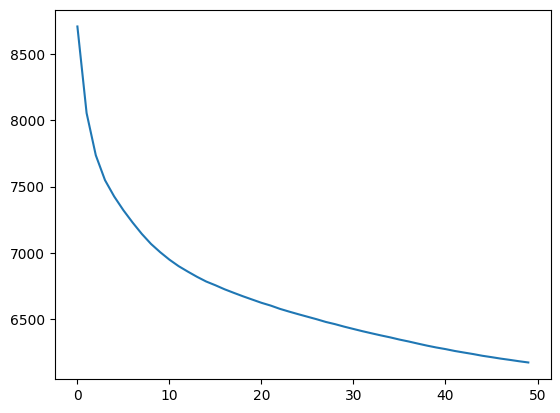

In [56]:
plt.plot(one_layer_history.history["loss"])

In [57]:
from pymongo import MongoClient

In [58]:
mongo = MongoClient("mongodb://10.122.6.17:27017")

In [59]:
database = "vnw_job"
col = "items"
data = list(mongo[database][col].find())

In [61]:
meta = pd.DataFrame(data)
meta.head()

,_id,dateProps,categoricalProps,floatProps,booleanProps
0,1601614,"{'expireDate': 2023-03-12 16:59:59, 'available...","{'locations': ['Ho Chi Minh'], 'jobLevel': ['E...",{},{}
1,1602060,"{'expireDate': 2023-03-16 16:59:59, 'available...","{'locations': ['Ho Chi Minh'], 'jobLevel': ['E...",{},{}
2,1602184,"{'expireDate': 2023-03-16 16:59:59, 'available...","{'locations': ['Ha Noi'], 'jobLevel': ['Experi...",{},{}
3,1602305,"{'expireDate': 2023-03-12 16:59:59, 'available...","{'locations': ['Ba Ria - Vung Tau'], 'jobLevel...",{},{}
4,1602625,"{'expireDate': 2023-03-17 16:59:59, 'available...","{'locations': ['Ha Noi', 'Bac Ninh', 'Thai Ngu...",{},{}


In [63]:
meta.categoricalProps[0]

{'locations': ['Ho Chi Minh'],
 'jobLevel': ['Experienced (non-manager)'],
 'industries': ['Advertising/Promotion/PR', 'Marketing', 'TV/Media/Newspaper'],
 'skills': ['truyen thong',
  'su kien',
  'event and pr',
  'xay dung thuong hieu',
  'branding'],
 'jobTitle': ['chuyen vien to chuc su kien event']}

In [69]:
import datetime

str(meta.dateProps[0]['expireDate'])

'2023-03-12 16:59:59'

In [119]:
meta['jobTitle'] = meta.categoricalProps.apply(lambda x: x["jobTitle"][0])
meta['skills'] = meta.categoricalProps.apply(lambda x: ','.join(x["skills"]))
meta['industries'] = meta.categoricalProps.apply(lambda x: ','.join(x["industries"]))
meta['locations'] = meta.categoricalProps.apply(lambda x: ','.join(x["locations"]))
meta['jobLevel'] = meta.categoricalProps.apply(lambda x: ','.join(x["jobLevel"]))
meta['availableDate'] = meta.dateProps.apply(lambda x: x["availableDate"])

In [120]:
meta[["_id", "jobTitle", "skills", "industries", "locations", "jobLevel", "availableDate"]].head()

,_id,jobTitle,skills,industries,locations,jobLevel,availableDate
37,985340,brand manager fmcg luong cung 20 25 trieu thuo...,"brand management,fmcg,brand planning,brand mar...","Advertising/Promotion/PR,Marketing,FMCG",Ha Noi,Manager,2023-02-13 08:14:32
1658,943784,nhan vien ke toan,"ke toan,tai chinh,cong no","Accounting,Sales,Warehouse",Ho Chi Minh,Experienced (non-manager),2023-02-13 03:33:36
8283,880110,nhan vien ke toan tong hop,"quyet toan thue,tai chinh,ke toan,quan li cong...","Accounting,Auditing,Finance/Investment",Ha Noi,Experienced (non-manager),2023-03-06 09:08:17
13377,878518,chuyen vien xu ly no,"xu ly no xau,xu ly no ban le,thu hoi no,ngan h...","Legal/Contracts,Banking","Kien Giang,Bac Lieu,Ho Chi Minh",Experienced (non-manager),2023-03-22 06:41:37
4648,863134,admin thu ky van phong,"giay to phap ly,thanh toan thu chi,xu ly cong ...","Administrative/Clerical,Legal/Contracts,Financ...",Ho Chi Minh,Experienced (non-manager),2023-02-22 07:25:47


In [121]:
meta.jobLevel.value_counts()

Experienced (non-manager)    14417
Manager                       3512
Fresher/Entry level            674
Director and above             597
Intern/Student                 105
Name: jobLevel, dtype: int64

In [122]:
from functools import reduce

a = []
for i in meta.categoricalProps.values.tolist():
    a += i["skills"]

In [123]:
meta[meta.jobTitle.str.contains("kinh nghiem")]

,_id,dateProps,categoricalProps,floatProps,booleanProps,jobTitle,skills,industries,locations,jobLevel,availableDate
19150,1638662,"{'availableDate': 2023-04-11 06:12:43, 'expire...","{'locations': ['Ho Chi Minh', 'Ha Noi'], 'jobL...",{},{},ky su trien khai khong yeu cau kinh nghiem,"cong nghe thong tin,dien tu vien thong","Telecommunications,IT - Hardware/Networking,El...","Ho Chi Minh,Ha Noi",Fresher/Entry level,2023-04-11 06:12:43
19098,1638595,"{'availableDate': 2023-04-11 04:03:03, 'expire...","{'locations': ['Ha Noi'], 'jobLevel': ['Experi...",{},{},ke toan vien uu tien co kinh nghiem gia thanh,"ke toan san xuat,gia thanh,product costing,ke ...","Accounting,Auditing,Finance/Investment",Ha Noi,Experienced (non-manager),2023-04-11 04:03:03
18869,1638287,"{'expireDate': 2023-05-10 16:59:59, 'available...","{'locations': ['Ha Noi'], 'jobLevel': ['Experi...",{},{},chuyen vien dich vu khach hang yeu cau kinh ng...,"cham soc khach hang,chung khoan dau tu,call ce...","Customer Service,Securities & Trading,Finance/...",Ha Noi,Experienced (non-manager),2023-04-10 08:33:49
18843,1638272,"{'availableDate': 2023-04-10 08:05:41, 'expire...","{'locations': ['Ho Chi Minh'], 'jobLevel': ['E...",{},{},chuyen vien tu van tai chinh cao cap khong yc ...,"ban hang,tu van,cham soc khach hang,telesale s...","Consulting,Insurance,Sales",Ho Chi Minh,Experienced (non-manager),2023-04-10 08:05:41
18819,1638243,"{'availableDate': 2023-04-10 07:24:39, 'expire...","{'locations': ['Ha Noi'], 'jobLevel': ['Experi...",{},{},nhan vien ke toan tu 1 nam kinh nghiem,"ke toan thue,ke toan,ke toan tong hop,kiem toa...","Accounting,Auditing",Ha Noi,Experienced (non-manager),2023-04-10 07:24:39
...,...,...,...,...,...,...,...,...,...,...,...
242,1606111,"{'expireDate': 2023-03-18 16:59:59, 'available...","{'locations': ['Ha Noi'], 'jobLevel': ['Experi...",{},{},nhan vien ke toan co kinh nghiem xnk,"account receivable,accounting,ke toan,export d...","Accounting,Civil/Construction,Export-Import",Ha Noi,Experienced (non-manager),2023-02-16 10:28:15
22,1603151,"{'expireDate': 2023-03-18 16:59:59, 'available...","{'locations': ['Ha Noi'], 'jobLevel': ['Freshe...",{},{},nhan vien kinh doanh chap nhan uv chua co kinh...,"tu van khach hang,kinh doanh du an,tim kiem kh...","Customer Service,Sales,Planning/Projects",Ha Noi,Fresher/Entry level,2023-02-16 03:54:22
20,1603109,"{'expireDate': 2023-03-15 16:59:59, 'available...","{'locations': ['Ho Chi Minh'], 'jobLevel': ['F...",{},{},nhan vien quan he khach hang ca nhan luong cun...,"ban hang bao hiem,cham soc khach hang,thuyet p...","Marketing,Retail/Wholesale,Sales",Ho Chi Minh,Fresher/Entry level,2023-02-13 06:14:42
13911,1531397,"{'expireDate': 2023-04-22 16:59:59, 'available...","{'locations': ['Ha Noi'], 'jobLevel': ['Experi...",{},{},nhan vien kinh doanh biet tieng trung khong ye...,"tieng trung,bao gia khach hang,cham soc khach ...","Customer Service,Environment/Waste Services,Sales",Ha Noi,Experienced (non-manager),2023-03-23 10:28:52


In [125]:
meta = meta.sort_values(by=['_id'], ascending=False)[["_id", "jobTitle", "skills", "industries", "locations", "jobLevel", "availableDate"]]
meta

,_id,jobTitle,skills,industries,locations,jobLevel,availableDate
37,985340,brand manager fmcg luong cung 20 25 trieu thuo...,"brand management,fmcg,brand planning,brand mar...","Advertising/Promotion/PR,Marketing,FMCG",Ha Noi,Manager,2023-02-13 08:14:32
1658,943784,nhan vien ke toan,"ke toan,tai chinh,cong no","Accounting,Sales,Warehouse",Ho Chi Minh,Experienced (non-manager),2023-02-13 03:33:36
8283,880110,nhan vien ke toan tong hop,"quyet toan thue,tai chinh,ke toan,quan li cong...","Accounting,Auditing,Finance/Investment",Ha Noi,Experienced (non-manager),2023-03-06 09:08:17
13377,878518,chuyen vien xu ly no,"xu ly no xau,xu ly no ban le,thu hoi no,ngan h...","Legal/Contracts,Banking","Kien Giang,Bac Lieu,Ho Chi Minh",Experienced (non-manager),2023-03-22 06:41:37
4648,863134,admin thu ky van phong,"giay to phap ly,thanh toan thu chi,xu ly cong ...","Administrative/Clerical,Legal/Contracts,Financ...",Ho Chi Minh,Experienced (non-manager),2023-02-22 07:25:47
...,...,...,...,...,...,...,...
1858,1208162,nhan vien it logistics,"server,phan cung,helpdesk,he thong mang,mcse","IT - Software,Freight/Logistics,IT - Hardware/...",Ha Noi,Experienced (non-manager),2023-02-13 08:44:32
2141,1193291,03 merchandiser,"english skill,garment manufacturing","Export-Import,Merchandising/Purchasing/Supply ...",Ho Chi Minh,Experienced (non-manager),2023-02-14 04:58:36
3953,1064810,chuyen vien kinh doanh giai phap cntt luong cu...,"giai phap cong nghe,cong nghe thong tin,kinh d...","Sales,Sales Technical,IT - Software",Ha Noi,Experienced (non-manager),2023-02-20 09:47:52
11969,1020099,vi tri nhan vien kinh doanh sales quoc te thu ...,"kinh doanh,sales skill,import export,tim kiem ...","Export-Import,Marketing,Sales","Ha Noi,Hung Yen",Experienced (non-manager),2023-03-17 07:00:36
